In [37]:
import cv2
import numpy as np
import os
import sys
import random
import itertools
import colorsys

import PIL.Image
from PIL import Image
import time
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon

In [2]:
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [4]:
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
# Change the config infermation
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1

In [6]:
config = InferenceConfig()

# COCO dataset object names
model = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
model.load_weights(COCO_MODEL_PATH, by_name=True)
class_names = [
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

In [7]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [8]:
def apply_mask(image, mask):
    image[:, :, 0] = np.where(
        mask == 1,
        125,
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 1,
        12,
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 1,
        15,
        image[:, :, 2]
    )
    return image

In [9]:
image = cv2.imread("1.jpeg")
print(image.shape)

(900, 1350, 3)


In [10]:
height, width, channels = image.shape

In [11]:
results = model.detect([image], verbose=0)

In [12]:
print(results[0])

{'rois': array([[ 196,  402,  896,  827],
       [ 208,  729,  894, 1041],
       [ 187,  947,  889, 1347],
       [ 415, 1109,  723, 1176]]), 'class_ids': array([ 1,  1,  1, 28]), 'scores': array([0.99988806, 0.999303  , 0.9987577 , 0.9533285 ], dtype=float32), 'masks': array([[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],


In [13]:
r = results[0]

In [14]:
boxes = r['rois']
masks = r['masks']
class_ids = r['class_ids']
scores = r['scores']

In [15]:
n_instances = boxes.shape[0]
print(n_instances)

4


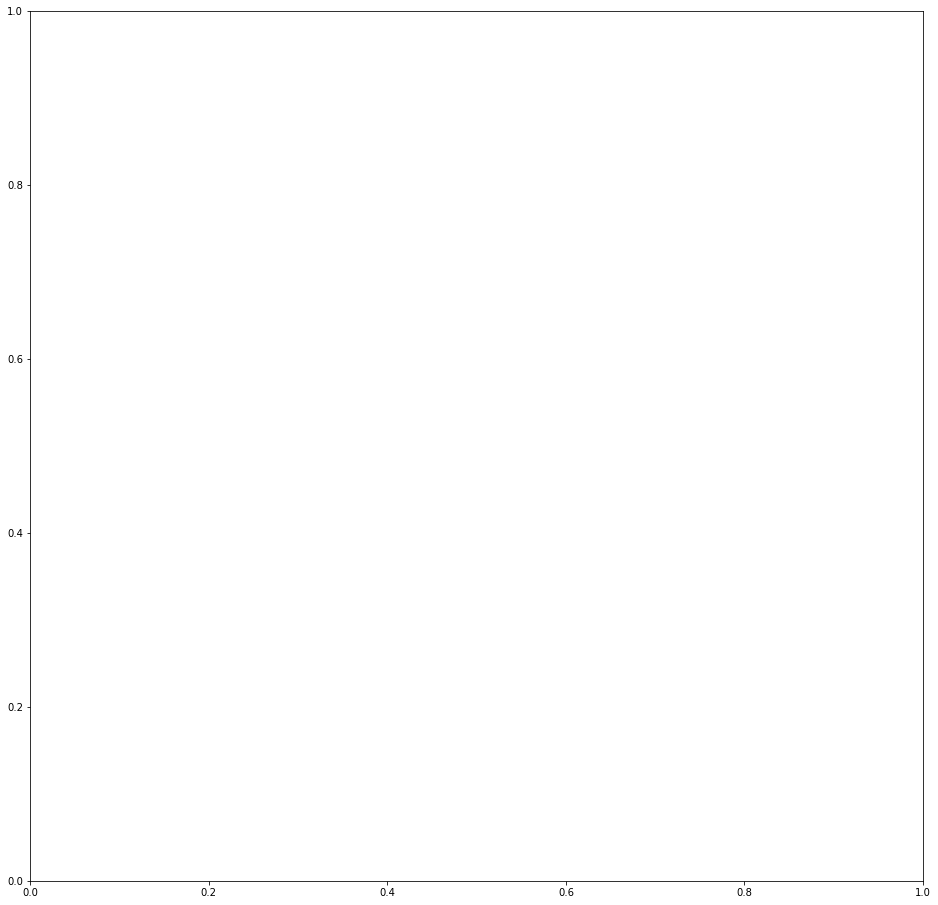

In [16]:
figsize=(16, 16)
_, ax = plt.subplots(1, figsize=figsize)

In [17]:
# Show area outside image boundaries.
height, width = image.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis('off')

(-10.0, 1360.0, 910.0, -10.0)

In [18]:
masked_image = image.astype(np.uint32).copy()

In [19]:
cv2.imshow("mask",masked_image.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
mask_total = np.zeros((masked_image.shape[0], masked_image.shape[1]), dtype=np.uint8)
for i in range(n_instances):
    label = class_names[class_ids[i]]
    color = "w"
    
    if label == 'person':            
        # Mask
        mask = masks[:, :, i]
        mask_int = mask.astype(int)
#         print(mask_int)
        mask_total=mask_total + mask
        
    
        
        
#         masked_image = apply_mask(masked_image, mask)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 1)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor="none")
            ax.add_patch(p)
            ax.imshow()

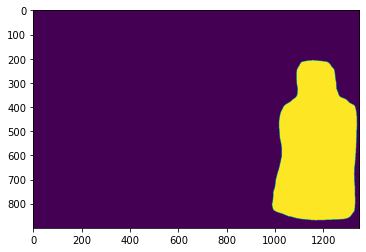

In [26]:
plt.imshow(mask.astype(np.uint8))

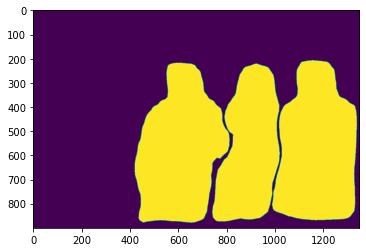

In [27]:
plt.imshow(mask_total)

In [28]:
cv2.imshow("mask",masked_image.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [95]:
mask_total_img= np.zeros((masked_image.shape[0], masked_image.shape[1],3), dtype=np.uint8)
for i in range(0,3):
    mask_total_img[:,:,i] = mask_total
print(mask_total_img.shape)
mask_total = mask_total * 255

(900, 1350, 3)


In [97]:
cv2.imshow("mask",mask_total.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [89]:
cv2.imwrite("mask_output.jpg",mask_total)

True